# Analysis of SAT Scores in New York High Schools
---

SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of __800__ points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets.

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

Let's read in the data below.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib as plt
%matplotlib inline

data_files = ["ap_2010.csv", "class_size.csv", "demographics.csv",
              "graduation.csv", "hs_directory.csv", "sat_results.csv"]
data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

Below, we'll read in data of survey responses from parents, teachers, and students at each school.

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", 
                         delimiter = "\t", 
                         encoding = 'windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", 
                         delimiter = "\t", 
                         encoding = 'windows-1252')

# Merge datasets
survey = pd.concat([all_survey, d75_survey], axis = 0)
survey["DBN"] = survey["dbn"]

# Columns to keep
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p",
                 "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11",
                 "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11",
                 "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", 
                 "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11",]

survey = survey.loc[:,survey_fields]

# Add survey to the data dictionary
data["survey"] = survey

As some of the datasets do not have a District Borough Number (DBN) so serve as a unique identifier for that school, we address this below.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

For our succeeding analyses, we need the data to be numeric so we perform transformations in the code cell below.

Also, we extract the longitude and latitude for each school for when we plot maps later on.

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# Getting sat_score as sum of average scores
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Getting latitude
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Getting longitude
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

To address multiple/non-unique entries in the datasets, we filter some of them according to only what we need:
- for `class_size`, we're only interested in `GRADE == 09-12` since we're looking at HS data as well as those in the general education program type.
- for `demographics`, we only get data for the academic year 2011 to 2012.
- for `graduation`, we only get data for graduates in 2006

In [5]:
# Filtering class_size
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# averaging by school
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

# Filtering demographics
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# Filtering graduation
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

Further converting some columns to be numeric.

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combining Datasets

We perform left join merges on the datasets below to combine them with DBN as the unique key.

For now, our data imputation method will be using the column means, imputing `0` when even the mean isn't available.

In [7]:
combined = data["sat_results"]

# Left Joins
combined = combined.merge(data["ap_2010"], on = "DBN", how = "left")
combined = combined.merge(data["graduation"], on = "DBN", how = "left")

# Merging datasets
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# Data Imputation
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

Since we wil be mapping some of the data later on, it will be better to map them by district later on since having too many individual data points on the plots may make getting insights harder.

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Correlational Analysis

Now we're ready to get the correlations and analyze them accordingly!

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Let's first visualize the correlations between fields in `survey` and `sat_score`. 

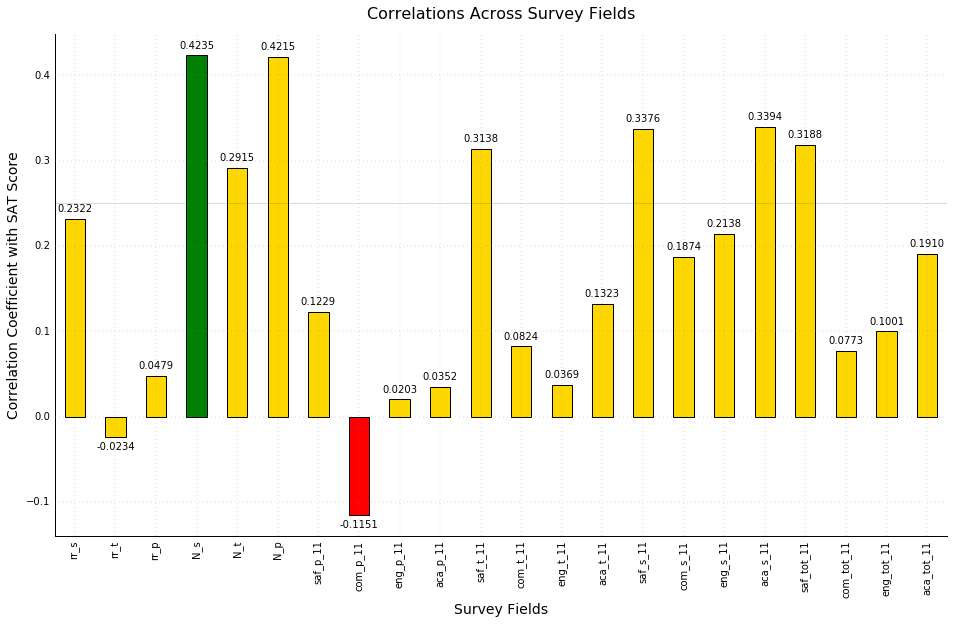

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

survey_corrs = correlations[survey_fields]

ax = survey_corrs.plot(kind = "bar", figsize = (16, 9), color = "gold")

ax.spines["right"].set_visible(False)    
ax.spines["top"].set_visible(False)
ax.set_ylim(min(survey_corrs) - 0.025, max(survey_corrs) + 0.025)
ax.set_xlabel("Survey Fields", size = 14)
ax.set_ylabel("Correlation Coefficient with SAT Score", size = 14)
ax.set_title("Correlations Across Survey Fields", size = 16, y = 1.02)
ax.tick_params(bottom = "off", top = "off", left = "off", right = "off")
ax.grid(True, color = "gray", linewidth = 0.30)
ax.axhline(0.25, c = "green", alpha = 0.2)

ax.patches[3].set_facecolor("green")
ax.patches[7].set_facecolor("red")

def add_value_labels(ax, spacing = 5):
    """
    Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axesof the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        if rect.get_y() < 0:
            y_value = rect.get_y()
        else:
            y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        
        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.4f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                        # Use `label` as label
            (x_value, y_value),           # Place label at end of the bar
            xytext = (0, space),          # Vertically shift label by `space`
            textcoords = "offset points", # Interpret `xytext` as offset in points
            ha = 'center',                # Horizontally center label
            va = va)                      # Vertically align label differently for
                                          # positive and negative values.

add_value_labels(ax)

If we are to consider correlations above `|0.25|` to be significantly high, then there are a couple of fields that correlate highly with SAT scores.
- Among those at the top ar `N_s`, `N_t`, and `N_p` which are _Number of student respondents_, _Number of teacher respondents_, and _Number of parent respondents_ respectively. This makes sense since these fields are highly correlated with `total_enrolment`.
- `saf_t_11` and `saf_s_11` on the other hand both deal with "Safety and Respect Scores" from teacher and student responses respectively. According to our graph above, higher perceptions of safety from these groups correlate with higher SAT scores. This is logical since a safer learning environment entails a better learning experience overall. This reflects the same as well with `saf_total_11`.
- Also worth mentioning is `rr_s` which is the student response rate. This means that the schools that had higher percentages of students that completed the survey also had higher SAT scores.
- Another interesting contrast is between the high positive correlation coefficient for `aca_s_11` which is the academic expectations score for the students, and the low coefficient for its teacher counterpart, `aca_t_11`, and even more so in parents with weak correlations in `aca_p_11`. This entails that higher perceived expectations from students drives higher SAT scores.
- Lastly, even though the coefficient displays a weak relationship, the lowest value is from the `com_p_11` field which is the communications score from parents' responses.

## Safety and SAT Performance

Let's delve further into the relationship between students' perception of safety in school and SAT scores.

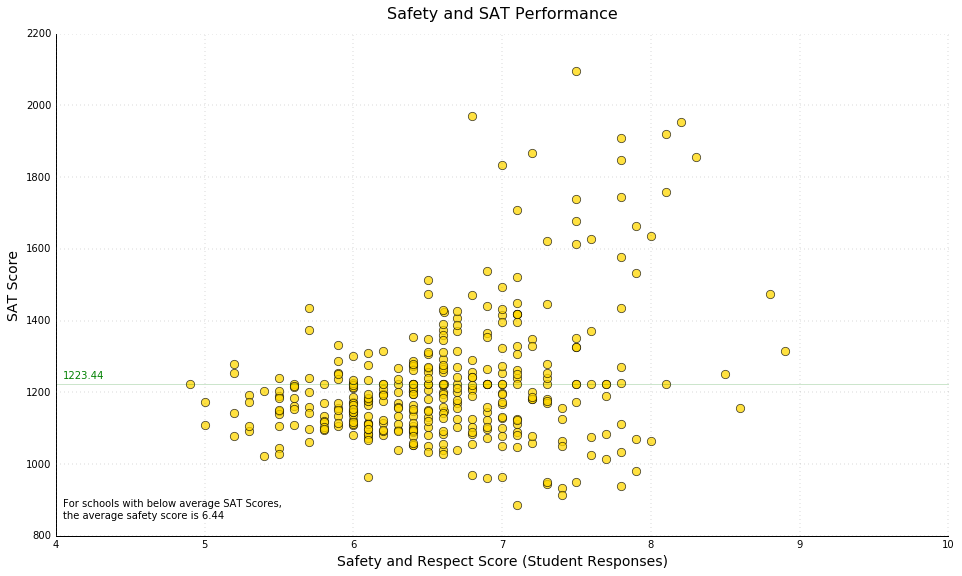

In [11]:
ax2 = combined.plot.scatter("saf_s_11", "sat_score", 
                            figsize = (16, 9 ), color = "gold",
                            s = 70, linewidth = 0.75, alpha = 0.75)

ax2.spines["right"].set_visible(False)    
ax2.spines["top"].set_visible(False)
ax2.set_xlabel("Safety and Respect Score (Student Responses)", size = 14)
ax2.set_ylabel("SAT Score", size = 14)
ax2.set_title("Safety and SAT Performance", size = 16, y = 1.02)
ax2.tick_params(bottom = "off", top = "off", left = "off", right = "off")
ax2.grid(True, color = "gray", linewidth = 0.30)

ave_sat = np.mean(combined["sat_score"])
ax2.axhline(ave_sat, c = "green", alpha = 0.2)
ax2.text(4.05, ave_sat + 15, str(round(ave_sat, 2)), color = "green")

below_ave_sat = combined[combined["sat_score"] < ave_sat]
b_ave_saf = round(np.mean(below_ave_sat["saf_s_11"]), 2)
ax2.text(4.05, 850, "For schools with below average SAT Scores, \nthe average safety score is {}".format(b_ave_saf))

The correlation between the students' perception of safety and the SAT scores seems to be not that apparent/strong, and may be driven by a few schools that have very high Safety scores and SAT scores. 

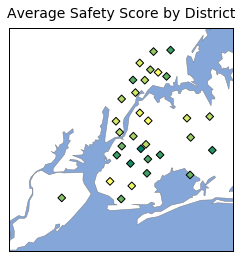

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Aggregating by district
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

# Setup Basemap for New York Mapping
m = Basemap(projection='merc', 
            llcrnrlat = 40.496044,
            urcrnrlat = 40.915256,
            llcrnrlon = -74.255735,
            urcrnrlon = -73.700272,
            resolution = 'h',
            anchor = "C")

# Add boundaries
m.drawmapboundary(fill_color = '#85A6D9')
m.drawcoastlines(color = 'gray', linewidth = .5)
m.drawrivers(color = 'gray', linewidth = .5)
m.fillcontinents(color = 'white', lake_color = '#85A6D9')

# Lats and Longs as lists
longitudes = districts["lon"].tolist()
latitudes  = districts["lat"].tolist()

m.scatter(longitudes, latitudes, s = 30, zorder = 2, latlon = True, 
          c = districts["saf_s_11"], cmap = "summer",
          marker = "D")

# for i in range(0, len(longitudes)):
#     x, y = map(longitudes[i], latitudes[i])
#     plt.text(x, y, districts["school_dist"][i],
#             fontsize=12,fontweight='bold',
#                     ha='left',va='bottom',color='k', latlon = True)

plt.title("Average Safety Score by District", size = 14, y = 1.02)
plt.show()

For the above map, green points correspond to lower safety scores while yellow points have higher safety scores.

It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

## Race and SAT Performance

There are a few columns that indicate the percentage of each race at a given school:
- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

By plotting out the correlations between these columns and `sat_score`, we can determine whether there are any racial differences in SAT performance.

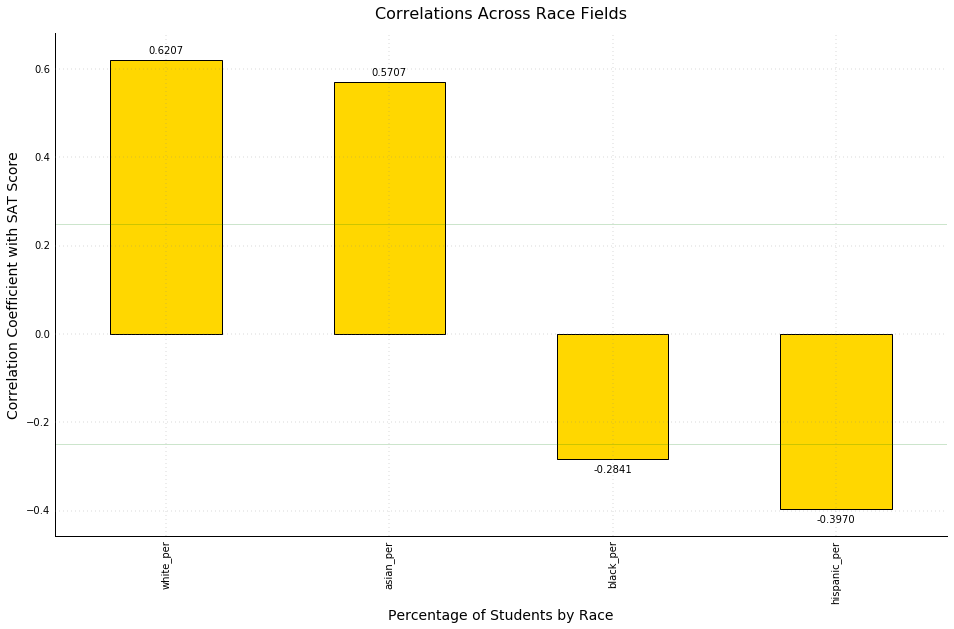

In [13]:
per_corrs = correlations[["white_per", "asian_per", "black_per", "hispanic_per"]]

ax3 = per_corrs.plot(kind = "bar", figsize = (16, 9), color = "gold")

ax3.spines["right"].set_visible(False)    
ax3.spines["top"].set_visible(False)
ax3.set_ylim(min(per_corrs) - 0.06, max(per_corrs) + 0.06)
ax3.set_xlabel("Percentage of Students by Race", size = 14)
ax3.set_ylabel("Correlation Coefficient with SAT Score", size = 14)
ax3.set_title("Correlations Across Race Fields", size = 16, y = 1.02)
ax3.tick_params(bottom = "off", top = "off", left = "off", right = "off")
ax3.grid(True, color = "gray", linewidth = 0.30)
ax3.axhline(0.25, c = "green", alpha = 0.2)
ax3.axhline(-0.25, c = "green", alpha = 0.2)

add_value_labels(ax3)

There seems to be a very large racial inequality in terms of race and SAT scores. Schools with higher percentage of white and asian students positively correlate with SAT scores, while schools with higher percentage of black and hispanic students correlate negatively.

This may be indicative of a systemic problem within the education system that puts schools in areas with more black and hispanic students at a disadvantage through less funding, more prevalent discrimination, and other factors.

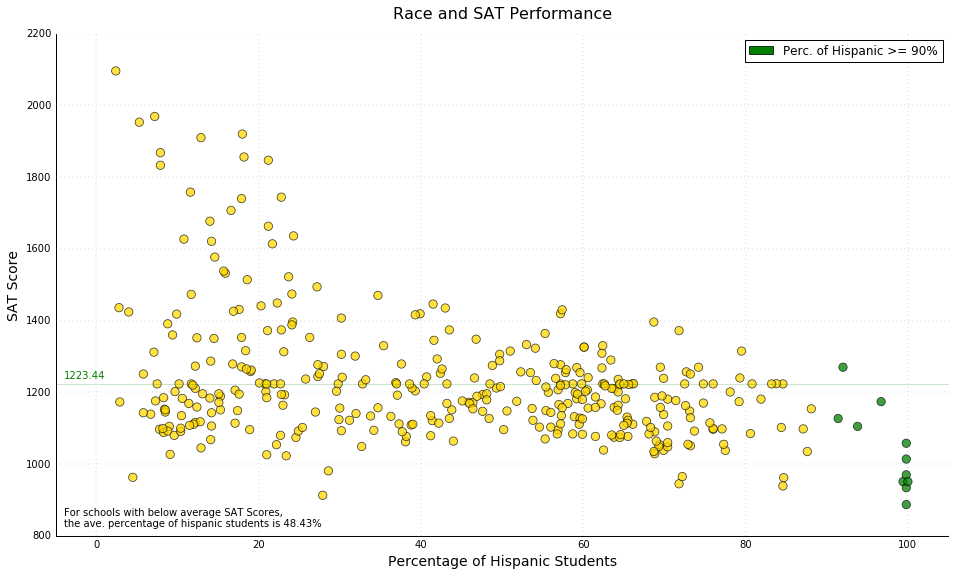

[SCHOOLS WITH PERC. HISPANIC STUDENTS > 90%]
1 Manhattan Bridges High School
2 City College Academy Of The Arts
3 Community Health Academy Of The Heights
4 Washington Heights Expeditionary Learning School
5 High School For International Business And Finance
6 Gregorio Luperon High School For Science And Mathematics
7 Academy For Language And Technology
8 International School For Liberal Arts
9 Pan American International High School At Monroe
10 Multicultural High School
11 Pan American International High School


In [14]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Boolean Array
colbool = (combined["hispanic_per"]  < 90)

def colbool_hisp(x):
    if x == True:
        return "gold"
    else:
        return "green"

color = colbool.apply(colbool_hisp)

ax4 = combined.plot.scatter("hispanic_per", "sat_score", 
                            figsize = (16, 9 ), color = color,
                            s = 70, linewidth = 0.75, alpha = 0.75)

ax4.spines["right"].set_visible(False)    
ax4.spines["top"].set_visible(False)
ax4.set_xlim(-5, 105)
ax4.set_xlabel("Percentage of Hispanic Students", size = 14)
ax4.set_ylabel("SAT Score", size = 14)
ax4.set_title("Race and SAT Performance", size = 16, y = 1.02)
ax4.tick_params(bottom = "off", top = "off", left = "off", right = "off")
ax4.grid(True, color = "gray", linewidth = 0.30)

# Add Legend
c = mpatches.Circle((0.5, 0.5), 0.25, facecolor = "green", edgecolor = "black", linewidth = 0.75)
ax4.legend([c], ["Perc. of Hispanic >= 90%"])

ave_sat = np.mean(combined["sat_score"])
ax4.axhline(ave_sat, c = "green", alpha = 0.2)
ax4.text(-4, ave_sat + 15, str(round(ave_sat, 2)), color = "green")

below_ave_sat = combined[combined["sat_score"] < ave_sat]
b_ave_hisp = round(np.mean(below_ave_sat["hispanic_per"]), 2)
ax4.text(-4, 825, "For schools with below average SAT Scores, \nthe ave. percentage of hispanic students is {}%".format(b_ave_hisp))

plt.show()

print("[SCHOOLS WITH PERC. HISPANIC STUDENTS > 90%]")
for i in range(0, len(combined[combined["hispanic_per"] > 90])):
    print(i + 1, combined[combined["hispanic_per"] > 90]["SCHOOL NAME"].values[i].title())

The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

## Gender and SAT Performance
There are two columns that indicate the percentage of each gender at a school:
- `male_per`
- `female_per`

We can plot out the correlations between each percentage and `sat_score`.

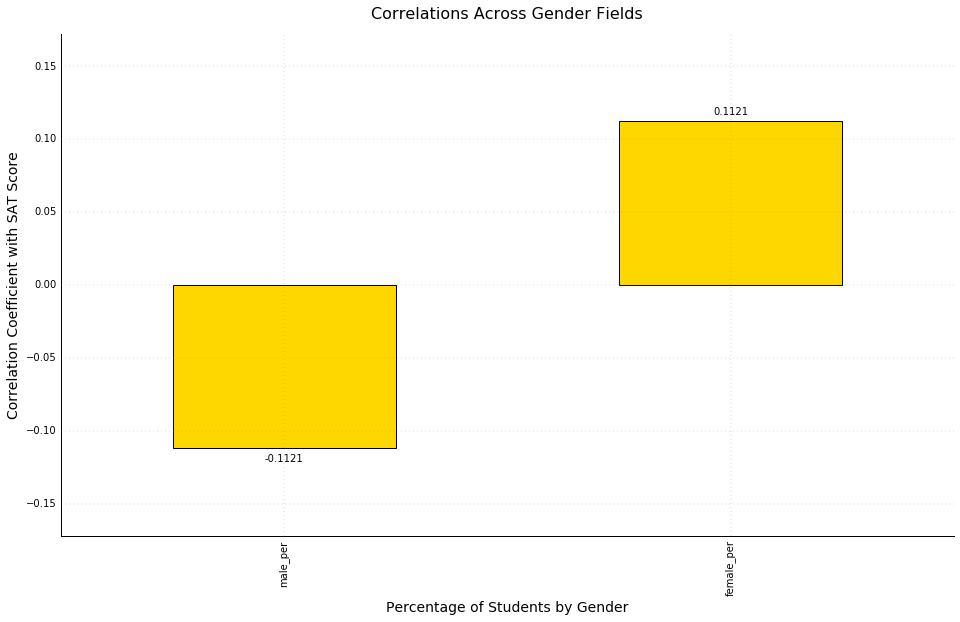

In [15]:
gend_corrs = correlations[["male_per", "female_per"]]

ax5 = gend_corrs.plot(kind = "bar", figsize = (16, 9), color = "gold")

ax5.spines["right"].set_visible(False)    
ax5.spines["top"].set_visible(False)
ax5.set_ylim(min(gend_corrs) - 0.06, max(gend_corrs) + 0.06)
ax5.set_xlabel("Percentage of Students by Gender", size = 14)
ax5.set_ylabel("Correlation Coefficient with SAT Score", size = 14)
ax5.set_title("Correlations Across Gender Fields", size = 16, y = 1.02)
ax5.tick_params(bottom = "off", top = "off", left = "off", right = "off")
ax5.grid(True, color = "gray", linewidth = 0.30)
ax5.axhline(0.25, c = "green", alpha = 0.2)
ax5.axhline(-0.25, c = "green", alpha = 0.2)

add_value_labels(ax5)


In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

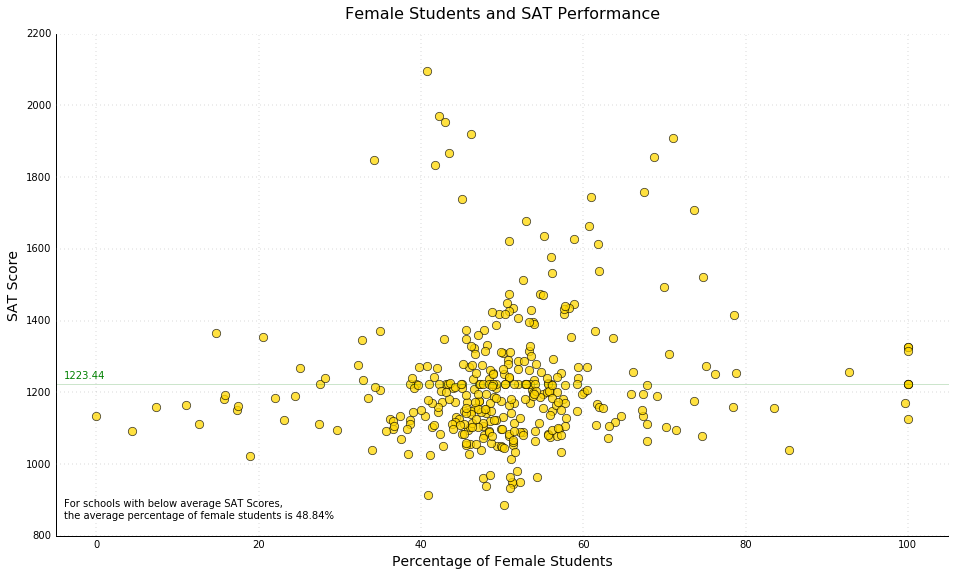

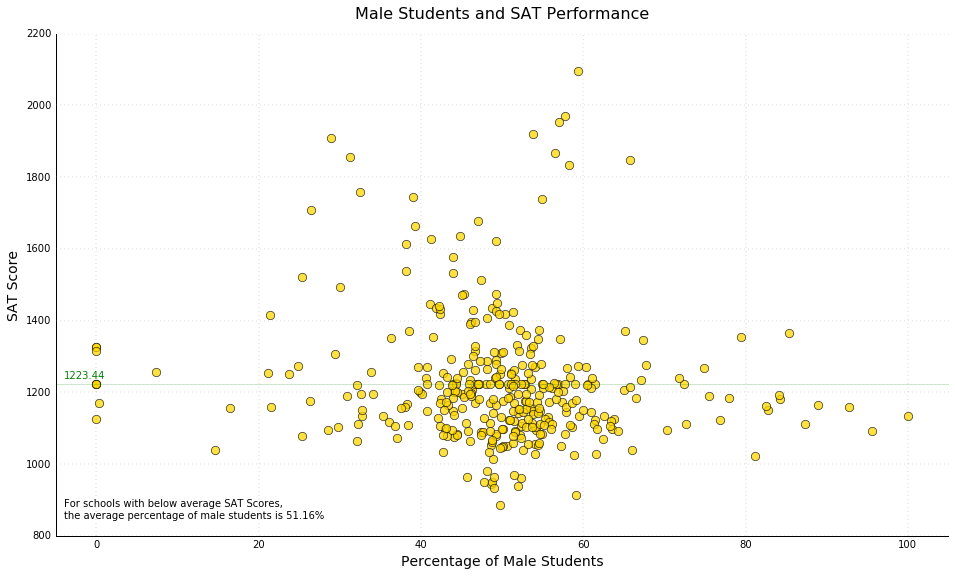

In [16]:
ax6 = combined.plot.scatter("female_per", "sat_score", 
                            figsize = (16, 9 ), color = "gold",
                            s = 70, linewidth = 0.75, alpha = 0.75)

ax6.spines["right"].set_visible(False)    
ax6.spines["top"].set_visible(False)
ax6.set_xlim(-5, 105)
ax6.set_xlabel("Percentage of Female Students", size = 14)
ax6.set_ylabel("SAT Score", size = 14)
ax6.set_title("Female Students and SAT Performance", size = 16, y = 1.02)
ax6.tick_params(bottom = "off", top = "off", left = "off", right = "off")
ax6.grid(True, color = "gray", linewidth = 0.30)

ave_sat = np.mean(combined["sat_score"])
ax6.axhline(ave_sat, c = "green", alpha = 0.2)
ax6.text(-4, ave_sat + 15, str(round(ave_sat, 2)), color = "green")

below_ave_sat = combined[combined["sat_score"] < ave_sat]
b_ave_fem = round(np.mean(below_ave_sat["female_per"]), 2)
ax6.text(-4, 850, "For schools with below average SAT Scores, \nthe average percentage of female students is {}%".format(b_ave_fem))

ax7 = combined.plot.scatter("male_per", "sat_score", 
                            figsize = (16, 9 ), color = "gold",
                            s = 70, linewidth = 0.75, alpha = 0.75)

ax7.spines["right"].set_visible(False)    
ax7.spines["top"].set_visible(False)
ax7.set_xlim(-5, 105)
ax7.set_xlabel("Percentage of Male Students", size = 14)
ax7.set_ylabel("SAT Score", size = 14)
ax7.set_title("Male Students and SAT Performance", size = 16, y = 1.02)
ax7.tick_params(bottom = "off", top = "off", left = "off", right = "off")
ax7.grid(True, color = "gray", linewidth = 0.30)

ave_sat = np.mean(combined["sat_score"])
ax7.axhline(ave_sat, c = "green", alpha = 0.2)
ax7.text(-4, ave_sat + 15, str(round(ave_sat, 2)), color = "green")

below_ave_sat = combined[combined["sat_score"] < ave_sat]
b_ave_mal = round(np.mean(below_ave_sat["male_per"]), 2)
ax7.text(-4, 850, "For schools with below average SAT Scores, \nthe average percentage of male students is {}%".format(b_ave_mal))

Based on the scatterplot, there doesn't seem to be any real correlation between `sat_score` and `female_per`. However, there is a cluster of schools with a high percentage of females (`60` to `80`), and high SAT scores.

In [18]:
fem_high = combined[(combined["female_per"] > 60) &
                    (combined["sat_score"] > 1700)]

print("[SCHOOLS WITH HIGH PERC. FEMALE STUDENTS AND HIGH SAT SCORES]")
for i in range(0, len(fem_high)):
    print(i + 1, fem_high["SCHOOL NAME"].values[i].title())

[SCHOOLS WITH HIGH PERC. FEMALE STUDENTS AND HIGH SAT SCORES]
1 Bard High School Early College
2 Eleanor Roosevelt High School
3 Beacon High School
4 Fiorello H. Laguardia High School Of Music & Art And Performing Arts
5 Townsend Harris High School


These schools appears to be very selective liberal arts schools that have high academic standards.

## Perc. of AP Takers and SAT Performance

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

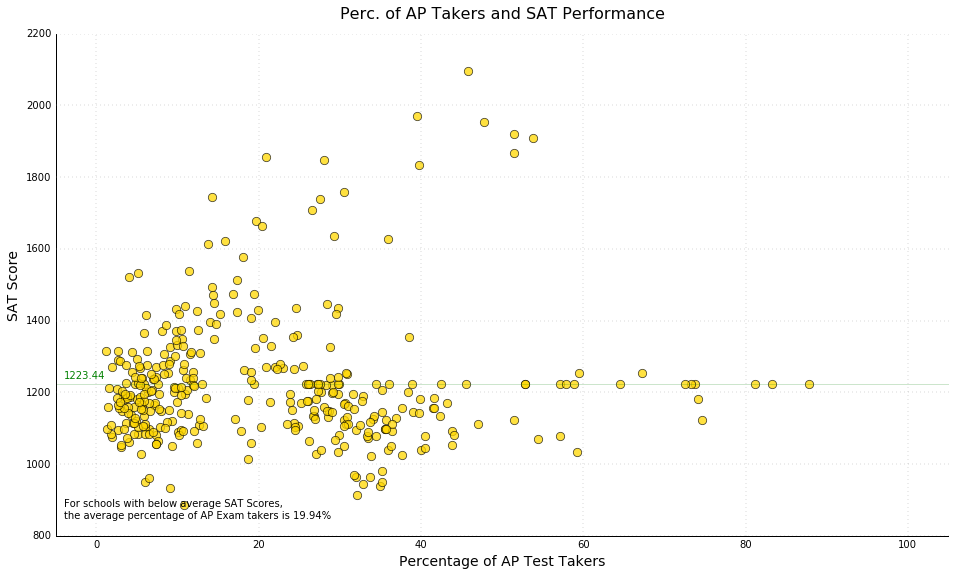

In [25]:
# Get perc. of students in each school that took and AP exam
combined["ap_per"] = (combined["AP Test Takers "]/combined["total_enrollment"])*100

ax8 = combined.plot.scatter("ap_per", "sat_score", 
                            figsize = (16, 9 ), color = "gold",
                            s = 70, linewidth = 0.75, alpha = 0.75)

ax8.spines["right"].set_visible(False)    
ax8.spines["top"].set_visible(False)
ax8.set_xlim(-5, 105)
ax8.set_xlabel("Percentage of AP Test Takers", size = 14)
ax8.set_ylabel("SAT Score", size = 14)
ax8.set_title("Perc. of AP Takers and SAT Performance", size = 16, y = 1.02)
ax8.tick_params(bottom = "off", top = "off", left = "off", right = "off")
ax8.grid(True, color = "gray", linewidth = 0.30)

ave_sat = np.mean(combined["sat_score"])
ax8.axhline(ave_sat, c = "green", alpha = 0.2)
ax8.text(-4, ave_sat + 15, str(round(ave_sat, 2)), color = "green")

below_ave_sat = combined[combined["sat_score"] < ave_sat]
b_ave_ap = round(np.mean(below_ave_sat["ap_per"]), 2)
ax8.text(-4, 850, "For schools with below average SAT Scores, \nthe average percentage of AP Exam takers is {}%".format(b_ave_ap))


There seems to be a weak positive correlation between the percentage of students in a school who take the AP exam, and their average SAT scores.